In [1]:
import numpy

import rscha2d
import fibonacci_sphere
import trig
import constants
import coords
import gauge

from matplotlib import pyplot, colors, ticker
%matplotlib nbagg

In [2]:
lat_c = 42.0
lon_c = 20.0
theta_c, phi_c, theta_0d, theta_0 = numpy.deg2rad((90-lat_c, lon_c, 26.0, 50.0))
knots_bd = numpy.arange(-2100, 2050, 50)

theta_m, phi_m = fibonacci_sphere.grid(5000)
in_cap = trig.angulardist(theta_m, phi_m, theta_c, phi_c) < theta_0d
theta_m = theta_m[in_cap]; phi_m = phi_m[in_cap]

r_m = numpy.ones_like(theta_m)*constants.a_r
times_dbd, r_dbd, theta_dbd, phi_dbd = coords.anything(r_m, theta_m, phi_m, knots_bd)

In [3]:
model = rscha2d.Model()
model.set_model_params(theta_c, phi_c, theta_0d,
                       cap_edge=0, kmax_int=3, kmax_ext=3, m_max=2, g10_ref=-30,
                       knots=knots_bd,
                       spatial_reg=1e-4, temporal_reg=1e-2)

In [4]:
model.add_data("../data/rscha2d/bd_javi_21abril.dat")

0


In [5]:
solution = model.solve(complete=True)
g = solution["coefs"]

________________________________________________________________________________
[Memory] Calling rscha2d.model_matrix...
model_matrix(array([-2100., ...,  1990.]), array([ 6364.616525, ...,  6367.425097]), array([ 0.285267, ...,  0.254927]), array([ 1.717401, ...,  0.725822]), reverse_order=True)
____________________________________________________model_matrix - 10.7s, 0.2min


In [6]:
g

array([-2.08306728,  0.2502224 , -0.05313268, ..., -0.07921277,
        0.1457284 ,  0.01215455])

In [6]:
tau_range = numpy.logspace(-6, 2, 10)
alfa_range = numpy.logspace(-7, 1, 10)

norms_s = numpy.load("norms_s.npy")
norms_t = numpy.load("norms_t.npy")
gs = numpy.load("gs.npy")

In [7]:
n_regs = 17

tau_range = numpy.logspace(-8, 8, n_regs)
alfa_range = numpy.logspace(-8, 8, n_regs)

In [8]:
tau_range

array([  1.00000000e-08,   1.00000000e-07,   1.00000000e-06,
         1.00000000e-05,   1.00000000e-04,   1.00000000e-03,
         1.00000000e-02,   1.00000000e-01,   1.00000000e+00,
         1.00000000e+01,   1.00000000e+02,   1.00000000e+03,
         1.00000000e+04,   1.00000000e+05,   1.00000000e+06,
         1.00000000e+07,   1.00000000e+08])

In [18]:
norms_s = numpy.zeros((n_regs, n_regs))
norms_t = numpy.zeros((n_regs, n_regs))
gs = numpy.zeros((n_regs, n_regs, len(g)))

for i, tau in enumerate(tau_range):
    for j, alfa in enumerate(alfa_range):
        model.temporal_reg = tau
        model.spatial_reg = alfa
        sol = model.solve(complete=True)
        gs[i, j, :] = sol["coefs"]
        norms_t[i, j] = sol["norm_t"]
        norms_s[i, j] = sol["norm_s"]
        
        # big scronch
        print(gauge.gauge(n_regs*i + j + 1, n_regs**2), end="\r")
        
numpy.save("gs400.npy", gs)
numpy.save("norms_s400.npy", norms_s)
numpy.save("norms_t400.npy", norms_t)

In [9]:
norms_s = numpy.load("norms_s400.npy")
norms_t = numpy.load("norms_t400.npy")
gs = numpy.load("gs400.npy")

In [10]:
gs[tau_range == 1e-2, alfa_range == 1e-4]

array([[-2.08306728,  0.2502224 , -0.05313268, ..., -0.07921277,
         0.1457284 ,  0.01215455]])

In [103]:
D_rms = numpy.zeros_like(norms_s)
I_rms = D_rms.copy()
F_rms = D_rms.copy()
F_prms = D_rms.copy()
D_nrms = D_rms.copy()
I_nrms = D_rms.copy()
F_nrms = D_rms.copy()
A_nrms = D_rms.copy()
A_rms = D_rms.copy()

for i, tau in enumerate(tau_range):
    for j, alfa in enumerate(alfa_range):
        D_rem_bd, I_rem_bd, F_rem_bd = model.synth_data(
                                            model.tv, model.r_geo,
                                            model.theta_geo,
                                            model.phi_geo, gs[i, j, :])
        D_rem_bd = trig.mindiff(D_rem_bd, 0)
        I_rem_bd = trig.mindiff(I_rem_bd, 0)
        
        smin = 81/140*numpy.deg2rad(2.3)
        sigma_D = 81/140*model.a95/numpy.cos(model.I_o)
        sigma_D[numpy.isnan(sigma_D) | (sigma_D < smin)] = smin
        sigma_I = 81/140*model.a95
        sigma_I[numpy.isnan(sigma_I) | (sigma_I < smin)] = smin
        F_err = model.F_err.copy()
        F_err[(~model.nan_F & numpy.isnan(F_err)) | (F_err < 5.0)] = 5.0
        
        D_res_bd = trig.mindiff(D_rem_bd, model.D_o)[~model.nan_D]
        D_nres_bd = D_res_bd / sigma_D[~model.nan_D]
        I_res_bd = trig.mindiff(I_rem_bd, model.I_o)[~model.nan_I]
        I_nres_bd = I_res_bd / sigma_I[~model.nan_I]
        F_res_bd = (F_rem_bd - model.F_o)[~model.nan_F]
        F_pres_bd = F_res_bd/model.F_dip[~model.nan_F]
        F_nres_bd = F_res_bd / F_err[~model.nan_F]
    
        D_rms[i, j] = numpy.sqrt(numpy.average(D_res_bd**2))
        I_rms[i, j] = numpy.sqrt(numpy.average(I_res_bd**2))
        F_rms[i, j] = numpy.sqrt(numpy.average(F_res_bd**2))
        A_rms[i, j] = numpy.sqrt(numpy.average(
            numpy.concatenate((D_res_bd, I_res_bd, F_pres_bd))**2
        ))
    
        D_nrms[i, j] = numpy.sqrt(numpy.average(D_nres_bd**2))
        I_nrms[i, j] = numpy.sqrt(numpy.average(I_nres_bd**2))
        F_nrms[i, j] = numpy.sqrt(numpy.average(F_nres_bd**2))
        
        A_nrms[i, j] = numpy.sqrt(numpy.average(
            numpy.concatenate((D_nres_bd, I_nres_bd, F_nres_bd))**2
        ))
        
        print(gauge.gauge(10*i + j + 1, 100), end="\r")

________________________________________________________________________________
[Memory] Calling rscha2d.model_matrix...
model_matrix(array([-2100., ...,  1990.]), array([ 6364.616525, ...,  6367.425097]), array([ 0.285267, ...,  0.254927]), array([ 1.717401, ...,  0.725822]), array([  2.523927, ...,  21.198361]), array([ 22.055187, ...,  14.797886]), array([ 40.358322, ...,  30.44024 ]))
____________________________________________________model_matrix - 11.6s, 0.2min


In [9]:
sigma_I = 81/140*model.a95
sigma_I[numpy.isnan(model.a95)] = 81/140*numpy.deg2rad(4.3)
(I_rem_bd[~model.nan_I]-model.I_o[~model.nan_I])/sigma_I[~model.nan_I]

array([ 2.48686565, -4.27084326,  3.7291464 , ...,  7.44050109,
        5.55100654,  1.24447724])

In [10]:
sigma_I

array([ 0.0434213 ,  0.02827433,  0.0434213 , ...,  0.0434213 ,
        0.0434213 ,  0.0434213 ])

<IPython.core.display.Javascript object>


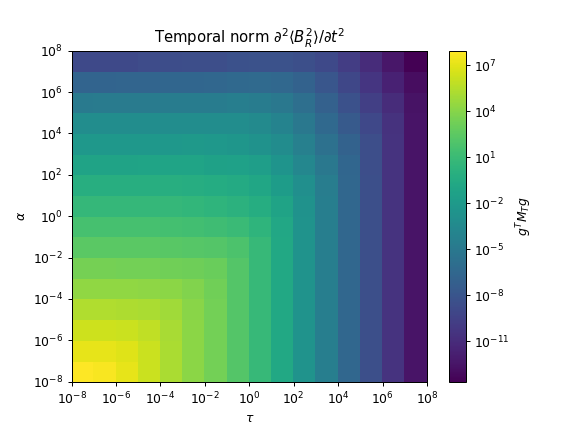

In [21]:
fig, ax = pyplot.subplots()

cbar=fig.colorbar(ax.pcolormesh(tau_range, alfa_range, norms_t,
                                norm=colors.LogNorm()))
cbar.set_label("$g^T M_T g$")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$\tau$")
ax.set_ylabel(r"$\alpha$")
ax.set_title(r"Temporal norm $\partial^2 \leftangle B_R^2 \rightangle /\partial t^2$")

pyplot.show(fig)

<IPython.core.display.Javascript object>


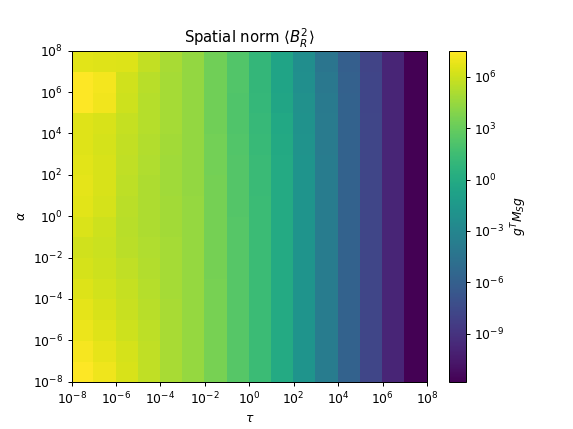

In [22]:
fig, ax = pyplot.subplots()

cbar=fig.colorbar(ax.pcolormesh(tau_range, alfa_range, norms_s,
                                norm=colors.LogNorm()))
cbar.set_label("$g^T M_S g$")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$\tau$")
ax.set_ylabel(r"$\alpha$")
ax.set_title(r"Spatial norm $\leftangle B_R^2\rightangle $")
pyplot.show(fig)

In [101]:
F_prms = F_rms / model.F_dip

ValueError: operands could not be broadcast together with shapes (17,17) (6766,) 

<IPython.core.display.Javascript object>


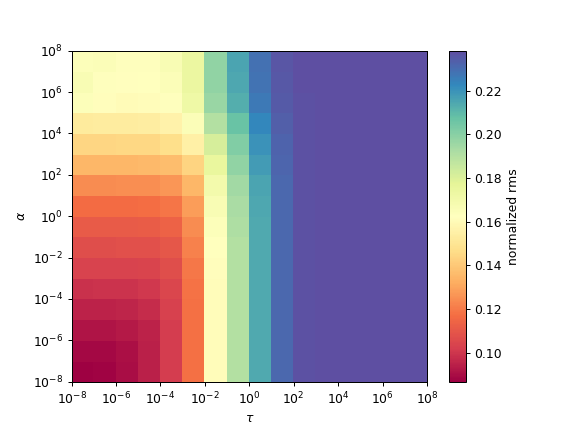

In [105]:
fig, ax = pyplot.subplots()

cbar=fig.colorbar(ax.pcolormesh(tau_range, alfa_range, A_rms, cmap="Spectral"))
cbar.set_label("normalized rms")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$\tau$")
ax.set_ylabel(r"$\alpha$")

pyplot.show(fig)

In [ ]:
# choose: tau = 1e-3

In [55]:
alfa_range[4]

0.0001

In [89]:
norms_s[tau_range == 1e-3]

array([[  1.98905103e+06,   1.09176689e+06,   4.53953189e+05,
          1.95459781e+05,   8.15700861e+04,   2.96464959e+04,
          3.25979730e+03,   2.63599698e+02,   2.36713682e+01,
          9.31893426e-01,   1.51559148e-02,   1.62376402e-04,
          1.63553142e-06,   1.63671854e-08,   1.63683736e-10,
          1.63684924e-12,   1.63685043e-14]])

####  nrms

<IPython.core.display.Javascript object>


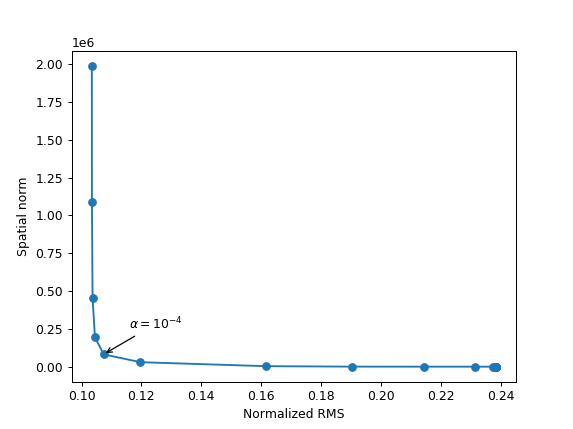

In [187]:
fig, ax = pyplot.subplots()

ax.plot(A_rms[tau_range == 1e-3, :].T,
        norms_s[tau_range == 1e-3, :].T, marker="o")

ax.annotate(r"$\alpha = 10^{-4} $", (A_rms[tau_range == 1e-3, alfa_range == 1e-4],
                     norms_s[tau_range == 1e-3, alfa_range == 1e-4]),
            xytext = (20, 20),
            textcoords="offset points", arrowprops={"arrowstyle" : "->"})

ax.set_xlabel("Normalized RMS")
ax.set_ylabel("Spatial norm")
#ax.yaxis.set_major_formatter(ticker.FixedFormatter())
ax.yaxis.get_major_formatter().set_powerlimits((-3, 4))

pyplot.show(fig)
fig.savefig("../data/regularization_alpha.png", frameon=True)

In [108]:
# choose: alfa = 1e-4

In [109]:
norms_t[alfa_range == 1e-4]

array([[  2.48023556e+04,   2.43987867e+04,   2.31673106e+04,
          2.01169447e+04,   1.42536661e+04,   7.21661435e+03,
          1.91109667e+03,   1.54268354e+02,   6.97496460e+00,
          1.91728591e-01,   3.02528420e-03,   3.24893801e-05,
          3.27361845e-07,   3.27611208e-09,   3.27636170e-11,
          3.27638666e-13,   3.27638916e-15]])

<IPython.core.display.Javascript object>


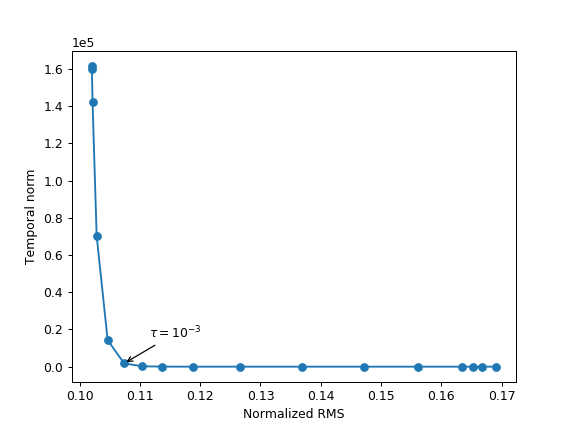

In [302]:
fig, ax = pyplot.subplots()

ax.plot(A_rms[:, alfa_range == 1e-4],
           norms_t[:, alfa_range == 1e-4], marker="o")

ax.annotate(r"$\tau = 10^{-3} $", (A_rms[tau_range == 1e-3, alfa_range == 1e-4],
                     norms_t[tau_range == 1e-3, alfa_range == 1e-4]),
            xytext = (20, 20),
            textcoords="offset points", arrowprops={"arrowstyle" : "->"})

ax.yaxis.get_major_formatter().set_powerlimits((-3, 4))
ax.set_xlabel("Normalized RMS")
ax.set_ylabel("Temporal norm")

pyplot.show(fig)
fig.savefig("../data/regularization_tau.png", frameon=True)

In [ ]:
# choose: tau = 1e-3?

## modelo óptimo

In [3]:
model = rscha2d.Model()
model.set_model_params(theta_c, phi_c, theta_0d,
                       cap_edge=0, kmax_int=3, kmax_ext=3, m_max=2, g10_ref=-30,
                       knots=knots_bd,
                       spatial_reg=1e-4, temporal_reg=0.5e-2)

In [4]:
model.add_data("../data/rscha2d/bd_javi_21abril.dat")

0


In [5]:
solution = model.solve(complete=True)
g = solution["coefs"]

________________________________________________________________________________
[Memory] Calling rscha2d.spatial_matrix...
spatial_matrix(array([ 6364.616525, ...,  6367.425097]), array([ 0.285267, ...,  0.254927]), array([ 1.717401, ...,  0.725822]), None, None, None)
__________________________________________________spatial_matrix - 10.7s, 0.2min


In [6]:
g

array([ -2.25537867e+00,   1.98794855e-01,  -1.09912172e-01, ...,
        -9.50720309e-02,   1.24434462e-01,   9.47886265e-04])

In [7]:
name_at = "Paris"
theta_at, phi_at = numpy.deg2rad((90-48.8, 2.35))

In [12]:
name_at = "Madrid"
theta_at, phi_at = numpy.deg2rad((90 - 40.423, -3.7))

In [17]:
name_at = "Sofia"
theta_at, phi_at = numpy.deg2rad((90 - 42.69, 23.32))

In [22]:
name_at = "Stockholm"
theta_at, phi_at = numpy.deg2rad((90 - 59.329, 18.068))

In [8]:
t_cur = numpy.linspace(-2000, 2000, 400)

near = (trig.angulardist(theta_at, phi_at, model.thetav, model.phiv) 
        < numpy.arctan(900/constants.a_r))

t_cur, r_cur, theta_cur, phi_cur = coords.curve_at(t_cur, constants.a_r, theta_at, phi_at)
D_cur_bd, I_cur_bd, F_cur_bd = model.synth_data(t_cur, r_cur, theta_cur, phi_cur, g)
D_cur_bd = trig.mindiff(D_cur_bd, 0)
I_cur_bd = trig.mindiff(I_cur_bd, 0)

________________________________________________________________________________
[Memory] Calling rscha2d.spatial_matrix...
spatial_matrix(array([ 6371.2, ...,  6371.2]), array([ 0.245882, ...,  0.245882]), array([-2.179337, ..., -2.179337]), array([-7.475448, ..., -7.475448]), array([-18.292138, ..., -18.292138]), array([ 45.144895, ...,  45.144895]))
___________________________________________________spatial_matrix - 0.8s, 0.0min


In [9]:
import geofield
import xyzfield

sha = geofield.SHADIFData("../data/sha.dif.14k/coeff_SHA.DIF.14k.dat",
                          "../data/sha.dif.14k/error_coef_EPSL_tnmgh.dat")

D_shadif = numpy.empty_like(sha.years)
I_shadif = numpy.empty_like(sha.years)
F_shadif = numpy.empty_like(sha.years)

years = numpy.array(sha.years)

for i, y in enumerate(sha.years):
    dec,inc,f,h = xyzfield.xyz2difh(*xyzfield.xyzfieldv2(sha.gcomp[i, :],
                                                         numpy.atleast_1d(phi_at),
                                                         numpy.atleast_1d(theta_at)))
    D_shadif[i] = dec
    I_shadif[i] = inc
    F_shadif[i] = f
    
D_shadif, I_shadif = numpy.rad2deg((D_shadif, I_shadif))

In [12]:
fake_model = rscha2d.Model()
fake_model.set_model_params(theta_c, phi_c, theta_0d,
                       cap_edge=0, kmax_int=3, kmax_ext=3, m_max=2, g10_ref=-30,
                       knots=knots_bd,
                       spatial_reg=1e-4, temporal_reg=1e-3)

fake_model.add_data("../data/rscha2d/GlobalDatabase-11Mayo2017.dat")

near = (trig.angulardist(theta_at, phi_at, fake_model.thetav, fake_model.phiv) 
        < numpy.arctan(900/constants.a_r))

lats = numpy.deg2rad(fake_model.lat[near])
lons = numpy.deg2rad(fake_model.lon[near])

lat_gsite = numpy.arctan(numpy.tan(fake_model.I_o[near])/2)
lat_vgp = numpy.arcsin(numpy.sin(lat_gsite)*numpy.sin(lats)
                       + numpy.cos(lat_gsite)*numpy.cos(lats)
                       *numpy.cos(fake_model.D_o[near]))
beta = numpy.arcsin(numpy.sin(fake_model.D_o[near])*numpy.cos(lat_gsite)
                    /numpy.cos(lat_vgp))

lon_vgp = numpy.zeros_like(lat_vgp)
big = (numpy.sin(lat_vgp)*numpy.sin(lats)) >= numpy.sin(lat_gsite)
lon_vgp[big] = numpy.pi + lons[big] - beta[big]
lon_vgp[~big] = lons[~big] + beta[~big]

lat_at = numpy.pi/2 - theta_at
lon_at = phi_at

lat_gat = numpy.arcsin(numpy.sin(lat_at)*numpy.sin(lat_vgp)
                       + numpy.cos(lat_at)*numpy.cos(lat_vgp)*
                       numpy.cos(lon_at - lon_vgp))

I_reloc = numpy.arctan(2*numpy.tan(lat_gat))
D_reloc = numpy.arcsin((numpy.sin(lon_vgp - lon_at)*numpy.cos(lat_vgp))
                       /numpy.cos(lat_at))

F_reloc = (fake_model.F_o[near]*numpy.sqrt(1+3*numpy.sin(lat_at)**2)
           / numpy.sqrt(1+3*numpy.sin(lats)**2))

1096


<IPython.core.display.Javascript object>


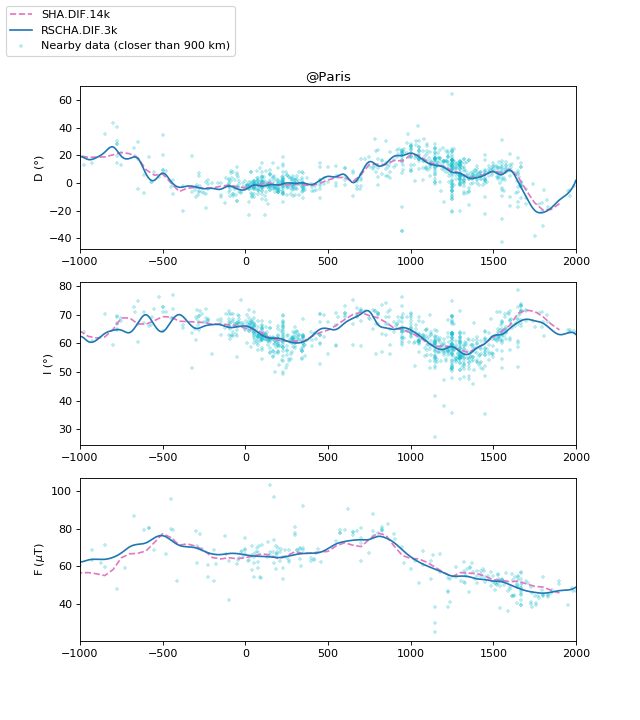

In [13]:
fig, (ax0, ax1, ax2) = pyplot.subplots(3,1, figsize=(8,9))

common={"marker" : "+", "s" : 8, "alpha" : 0.3, "color" : "C9"}
sha_style = {"color" : "C6", "linestyle" : "--"}
rscha_style = {"color" : "C0"}


#ax0.scatter(model.tv[near], numpy.rad2deg(model.D_o[near]),
#            label="Nearby data (closer than 900 km)", **common)
ax0.scatter(fake_model.tv[near], numpy.rad2deg(D_reloc),
            label="Nearby data (closer than 900 km)", **common)
ax0.plot(years, D_shadif, label="SHA.DIF.14k", **sha_style)
ax0.plot(t_cur, numpy.rad2deg(D_cur_bd), **rscha_style, label="RSCHA.DIF.3k")
ax0.set_ylabel("D (°)")


ax1.plot(years, I_shadif, **sha_style)
#ax1.scatter(model.tv[near], numpy.rad2deg(model.I_o[near]), **common)
ax1.scatter(fake_model.tv[near], numpy.rad2deg(I_reloc), **common)
ax1.plot(t_cur, numpy.rad2deg(I_cur_bd), **rscha_style)
ax1.set_ylabel("I (°)")

#ax2.scatter(model.tv[near], model.F_o[near], **common)
ax2.scatter(fake_model.tv[near], F_reloc, **common)
ax2.plot(years, F_shadif, **sha_style)
ax2.plot(t_cur, F_cur_bd, **rscha_style)
ax2.set_ylabel("F ($\mu $T)")

ax0.set_title("@{}".format(name_at))

for ax in (ax0, ax1, ax2):
    ax.set_xbound(-1000, 2000)
    
fig.legend(*ax0.get_legend_handles_labels(), loc="upper left")
fig.savefig(f"../data/curva_{name_at}.png", frameon=True)

In [425]:
D_rem_bd, I_rem_bd, F_rem_bd = model.synth_data(model.tv, model.r_geo,
                                                   model.theta_geo, model.phi_geo, g)
D_rem_bd = trig.mindiff(D_rem_bd, 0)
I_rem_bd = trig.mindiff(I_rem_bd, 0)

D_res_bd = trig.mindiff(D_rem_bd, model.D_o)[~model.nan_D]

I_res_bd = trig.mindiff(I_rem_bd, model.I_o)[~model.nan_I]
F_res_bd = (F_rem_bd - model.F_o)[~model.nan_F]

________________________________________________________________________________
[Memory] Calling rscha2d.model_matrix...
model_matrix(array([-2100., ...,  1990.]), array([ 6364.616525, ...,  6367.425097]), array([ 0.285267, ...,  0.254927]), array([ 1.717401, ...,  0.725822]), array([  2.523927, ...,  21.198361]), array([ 22.055187, ...,  14.797886]), array([ 40.358322, ...,  30.44024 ]))
____________________________________________________model_matrix - 10.9s, 0.2min


<IPython.core.display.Javascript object>


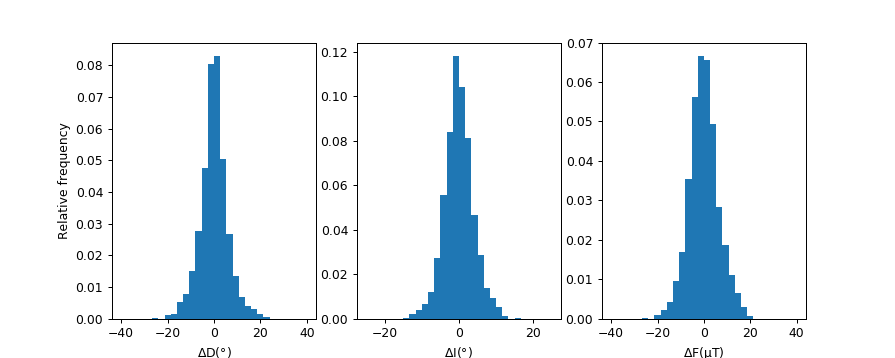

In [432]:
fig, axes = pyplot.subplots(nrows=1, ncols=3, figsize=(10, 4))

axes[0].hist(numpy.rad2deg(D_res_bd), color="C0",
             label="residuos (bd)", range=(-40, 40), normed=True, bins=30)
axes[0].set_xlabel("$\Delta $D(°)")

axes[1].hist(numpy.rad2deg(I_res_bd), color="C0",
             label="residuos (bd)", range=(-25, 25), normed=True, bins=30)
axes[1].set_xlabel("$\Delta $I(°)")

axes[2].hist(F_res_bd, color="C0",
             label="residuos (bd)", range=(-40, 40), normed=True, bins=30)
axes[2].set_xlabel("$\Delta $F(μT)")

axes[0].set_ylabel("Relative frequency")

pyplot.show(fig)
fig.savefig("../data/rscha2d/residuals.png", frameon=True)